In [466]:
import tensorflow as tf
import os
from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2
from ml_metadata.proto import metadata_store_service_pb2
from tensorflow.python.lib.io import file_io  # pylint: disable=g-direct-tensorflow-import
from tfx.orchestration import data_types
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.types import artifact_utils
from tfx.types.artifact import Artifact
from tfx.types.artifact import ArtifactState

In [467]:
#Node coloring helper
def color(pair):
    name = pair[1]
    if name == 'CsvExampleGen':
        return (0.53, 0.81, 0.92)
    elif name == 'StatisticsGen':
        return (1, 1, 0)
    elif name == 'SchemaGen':
        return (1, 0.55, 0)
    elif name == 'Transform':
        return (1, 0.71, 0.76)
    else:
        return (0.58, 0.44, 0.86)

def get_color(executions_list):
    color_list = map(color, executions_list)
    return list(color_list)

## Querying MLMD

In [468]:
_pipeline_name = 'chicago_taxi_beam'
_tfx_root = os.path.join(os.environ['HOME'], 'tfx')
metadata_path = os.path.join(_tfx_root, 'metadata', _pipeline_name, 'metadata.db')

In [469]:
mlmd_config = metadata.sqlite_metadata_connection_config(metadata_path)

In [470]:
connection = metadata.Metadata(mlmd_config)
store = metadata_store.MetadataStore(mlmd_config)

In [471]:
artifacts = store.get_artifacts()

In [472]:
artifact_ids = [art.id for art in artifacts]
labeled_artifact_ids = [f'a{id}' for id in artifact_ids]

In [473]:
executions = store.get_executions()
#filter executions with state = "complete"

In [474]:
execution_ids_query = [(exec.id,exec.properties['component_id'].string_value) for exec in executions if exec.properties['state'].string_value == 'complete']
execution_ids = [exec.id for exec in executions if exec.properties['state'].string_value == 'complete']
execution_labels = {}
labeled_execution_ids = [f'e{pair[0]}' for pair in execution_ids_query]
for pair in execution_ids_query:
    execution_labels[f'e{pair[0]}'] = pair[1]
execution_labels

{'e1': 'CsvExampleGen',
 'e2': 'StatisticsGen',
 'e3': 'CsvExampleGen',
 'e4': 'CsvExampleGen',
 'e5': 'StatisticsGen',
 'e6': 'CsvExampleGen',
 'e7': 'SchemaGen',
 'e8': 'CsvExampleGen',
 'e9': 'SchemaGen',
 'e10': 'Transform',
 'e11': 'StatisticsGen',
 'e12': 'CsvExampleGen',
 'e13': 'CsvExampleGen',
 'e16': 'CsvExampleGen',
 'e17': 'SchemaGen',
 'e18': 'StatisticsGen',
 'e19': 'CsvExampleGen',
 'e20': 'Trainer',
 'e21': 'Transform',
 'e23': 'SchemaGen',
 'e24': 'CsvExampleGen',
 'e25': 'StatisticsGen',
 'e27': 'CsvExampleGen',
 'e30': 'StatisticsGen',
 'e31': 'SchemaGen',
 'e32': 'CsvExampleGen',
 'e33': 'Transform',
 'e35': 'CsvExampleGen',
 'e36': 'SchemaGen',
 'e37': 'StatisticsGen',
 'e38': 'CsvExampleGen',
 'e40': 'Trainer',
 'e41': 'Transform',
 'e42': 'SchemaGen',
 'e43': 'CsvExampleGen',
 'e44': 'StatisticsGen',
 'e45': 'CsvExampleGen',
 'e50': 'CsvExampleGen',
 'e51': 'StatisticsGen',
 'e52': 'SchemaGen',
 'e53': 'CsvExampleGen',
 'e54': 'Transform',
 'e57': 'StatisticsGen'

In [475]:
events = store.get_events_by_execution_ids(execution_ids)

In [476]:
event_id_pairs = [(f'a{event.artifact_id}', f'e{event.execution_id}') for event in events]

## Visualizing Graph

In [477]:
import networkx as nx
import matplotlib.pyplot as plt

In [478]:
graph = nx.Graph()
graph.add_edges_from(event_id_pairs)

In [479]:
pos = nx.spring_layout(graph)

In [480]:
filtered_artifacts = list(set(pos.keys()) & set(labeled_artifact_ids))

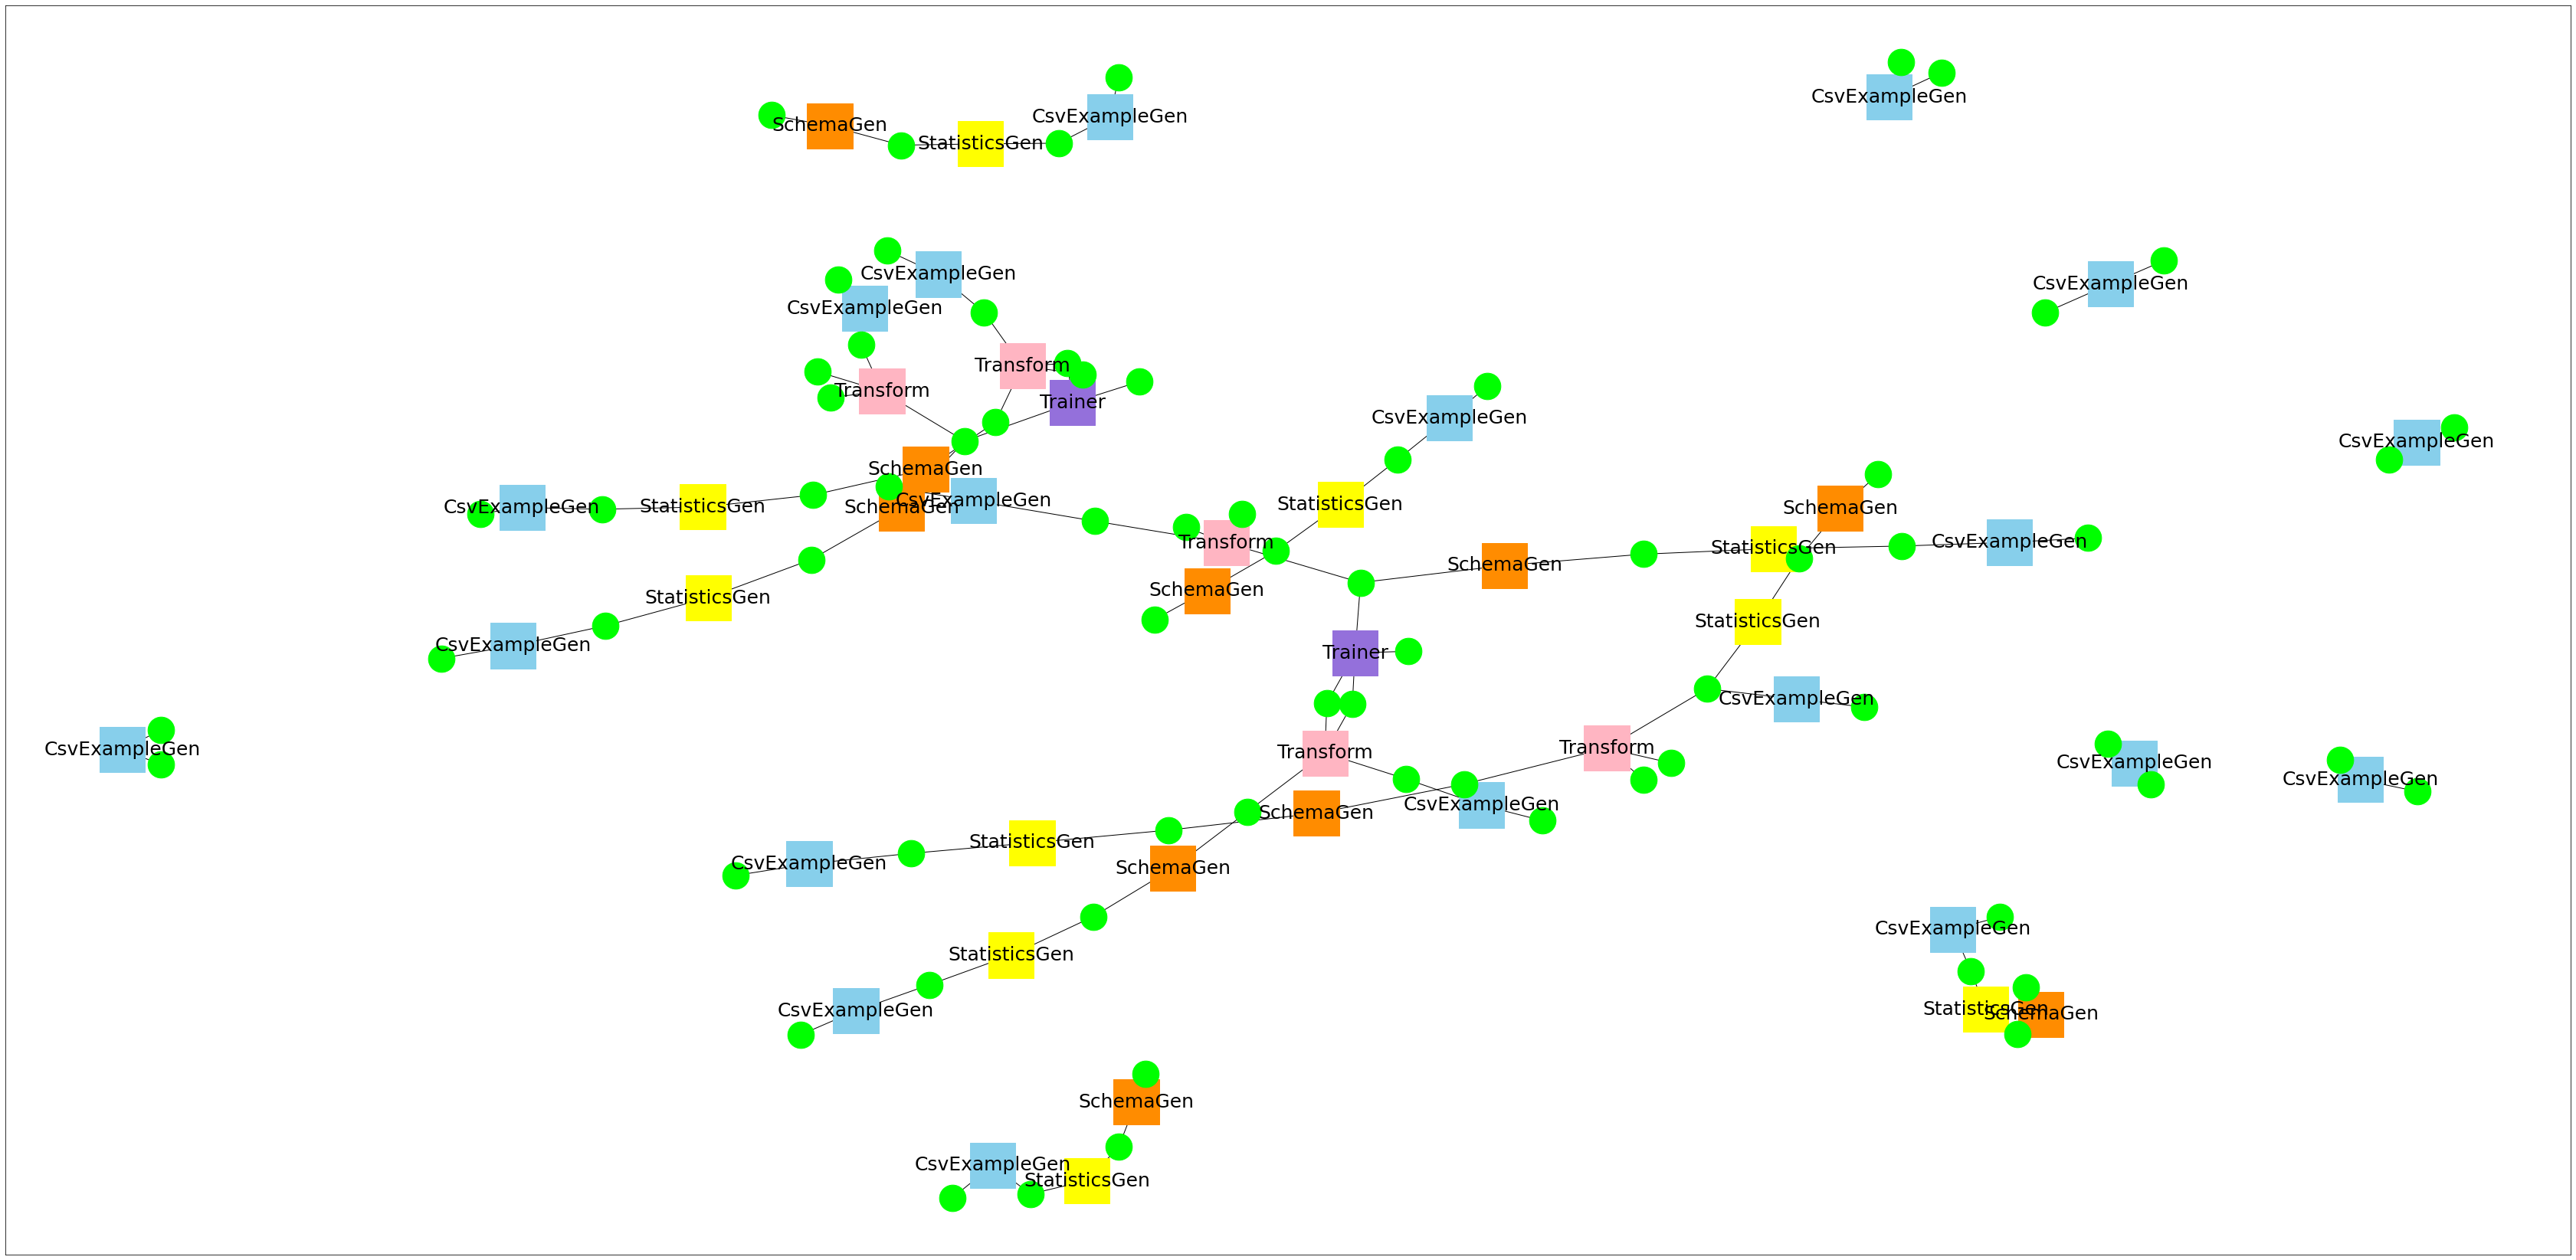

In [483]:
nx.draw_networkx_nodes(graph, pos, nodelist=labeled_execution_ids, node_color=get_color(execution_ids_query), node_size=3500, node_shape='s')
nx.draw_networkx_labels(graph, pos, execution_labels, font_size=25)
nx.draw_networkx_nodes(graph, pos, nodelist=filtered_artifacts, node_color=(0,1,0), node_size=1200)
nx.draw_networkx_edges(graph, pos, edgelist=event_id_pairs, arrows=False)
plt.rcParams['figure.figsize'] = [40, 20]
plt.draw()